In [20]:
# Stephen.Griffies@noaa.gov

In [21]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import signal as ss
from scipy import stats as sstat

%matplotlib inline
import mplsettings

from datetime import timedelta

print("numpy version  : ", np.__version__)
print("pandas version : ", pd.__version__)
print("xarray version : ", xr.__version__)

numpy version  :  1.23.5
pandas version :  2.0.0
xarray version :  2023.4.2


In [22]:
dirstix = "/net2/rnd/dev/stixfonts/fonts/static_ttf"
import matplotlib.font_manager as font_manager
for font in font_manager.findSystemFonts(dirstix):
    font_manager.fontManager.addfont(font)

# Set font family globally
plt.rcParams['font.family'] = 'STIX Two Text'

In [23]:
def welchs_95ci(y,f_s,window_width,overlap,n_fft):
    """                                                                                                                                                                                                                                                                                                                 
    Calculates 95% confidence intervals using a common method (e.g., used by MATLAB).                                                                                                                                                                                                                                   
    There is uncertainty in how to calculate degrees off reedom, though.                                                                                                                                                                                                                                                
                                                                                                                                                                                                                                                                                                                        
    Parameters                                                                                                                                                                                                                                                                                                          
    ----------                                                                                                                                                                                                                                                                                                          
    y : numpy.ndarray                                                                                                                                                                                                                                                                                                   
        Input time series.                                                                                                                                                                                                                                                                                              
    f_s : float                                                                                                                                                                                                                                                                                                         
        Sampling frequency in samples/yr                                                                                                                                                                                                                                                                                
    window_width : float                                                                                                                                                                                                                                                                                                
        Width of analysis window in yr                                                                                                                                                                                                                                                                                  
    overlap : float                                                                                                                                                                                                                                                                                                     
        Length of overlap between two adjacent analysis windows in yr                                                                                                                                                                                                                                                   
    n_fft : float                                                                                                                                                                                                                                                                                                       
        Number of FFT calculations to perform; data will be zero-padded to reach this length                                                                                                                                                                                                                            
                                                                                                                                                                                                                                                                                                                        
    Returns                                                                                                                                                                                                                                                                                                             
    -------                                                                                                                                                                                                                                                                                                             
    f_welch : numpy.ndarray                                                                                                                                                                                                                                                                                             
        One-sided frequency array corresponding to spectrum estimate.                                                                                                                                                                                                                                                   
    ps_welch : numpy.ndarray                                                                                                                                                                                                                                                                                            
        Spectrum estimate using Welch's method, manually applied.                                                                                                                                                                                                                                                       
    ci_lower : numpy.ndarray                                                                                                                                                                                                                                                                                            
        Lower values of 95% confidence interval.                                                                                                                                                                                                                                                                        
    ci_upper : numpy.ndarray                                                                                                                                                                                                                                                                                            
        Upper values of 95% confidence interval.                                                                                                                                                                                                                                                                        
                                                                                                                                                                                                                                                                                                                        
    """
    increment = window_width - overlap

    n_analyses = int((len(y)/f_s-window_width)/increment + 1)    # no. of analyses we will perform                                                                                                                                                                                                                      

    n_perseg = window_width*f_s                     # no. of samples per segment (i.e., per analysis window)                                                                                                                                                                                                            
    n_overlap = window_width*f_s-increment*f_s      # amount of overlap (in no. of samples) between adjacent analysis windows                                                                                                                                                                                           

    # built-in Welch's method routine                                                                                                                                                                                                                                                                                   
    f_welch,ps_welch = ss.welch(y, fs=f_s, window='hann', nperseg=n_perseg, noverlap=n_overlap, nfft=n_fft)

    # computing confidence intervals in a common way                                                                                                                                                                                                                                                                    
    # comes from: https://www.mathworks.com/matlabcentral/answers/522047-how-pwelch-computes-confidence-intervals                                                                                                                                                                                                       
    from scipy.stats import chi2

    P = n_analyses      # half of effective no. of degrees of freedom; still much debate about what this should be                                                                                                                                                                                                      

    probability = 0.95  # confidence level of interval                                                                                                                                                                                                                                                                  

    alpha = (1 - probability)/2
    nu = 2 * P      # number of degrees of freedom...many different opinions on what this is!                                                                                                                                                                                                                           
    c = chi2.ppf([1 - alpha, alpha], nu)     # percent point function of chi-squared dist. w/ degrees of freedom nu                                                                                                                                                                                                     
    c = nu / c

    ci_lower = ps_welch[1:] * c[0]
    ci_upper = ps_welch[1:] * c[1]

    return f_welch,ps_welch,ci_lower,ci_upper


In [24]:
def welchs_iqr(y,f_s,window_width,overlap,n_fft):
    """                                                                                                                                                                                                                                                                                                                 
    Calculates inter-quartile range of periodogram values from moving, overlapping analysis windows.                                                                                                                                                                                                                    
    This required manually applying Welch's method.'                                                                                                                                                                                                                                                                    
                                                                                                                                                                                                                                                                                                                        
    Parameters                                                                                                                                                                                                                                                                                                          
    ----------                                                                                                                                                                                                                                                                                                          
    y : numpy.ndarray                                                                                                                                                                                                                                                                                                   
        Input time series.                                                                                                                                                                                                                                                                                              
    f_s : float                                                                                                                                                                                                                                                                                                         
        Sampling frequency in samples/yr                                                                                                                                                                                                                                                                                
    window_width : float                                                                                                                                                                                                                                                                                                
        Width of analysis window in yr                                                                                                                                                                                                                                                                                  
    overlap : float                                                                                                                                                                                                                                                                                                     
        Length of overlap between two adjacent analysis windows in yr                                                                                                                                                                                                                                                   
    n_fft : float                                                                                                                                                                                                                                                                                                       
        Number of FFT calculations to perform; data will be zero-padded to reach this length                                                                                                                                                                                                                            
                                                                                                                                                                                                                                                                                                                        
    Returns                                                                                                                                                                                                                                                                                                             
    -------                                                                                                                                                                                                                                                                                                             
    f : numpy.ndarray                                                                                                                                                                                                                                                                                                   
        One-sided frequency array corresponding to spectrum estimate.                                                                                                                                                                                                                                                   
    ps_pgram : numpy.ndarray                                                                                                                                                                                                                                                                                            
        Spectrum estimate using Welch's method, manually applied.                                                                                                                                                                                                                                                       
    lower_iqr : numpy.ndarray                                                                                                                                                                                                                                                                                           
        Lower limit of IQR as function of frequency.                                                                                                                                                                                                                                                                    
    upper_iqr : numpy.ndarray                                                                                                                                                                                                                                                                                           
        Upper limit of IQR as function of frequency.                                                                                                                                                                                                                                                                    
                                                                                                                                                                                                                                                                                                                        
    """
    increment = window_width - overlap

    n_analyses = int((len(y)/f_s-window_width)/increment + 1)    # no. of analyses we will perform                                                                                                                                                                                                                      

    pgram_all = np.zeros((n_analyses,int(n_fft/2+1)))   # allocating memory for all analyses                                                                                                                                                                                                                            

    # calculate periodograms using a moving Hanning window                                                                                                                                                                                                                                                              
    for i in np.arange(n_analyses):
        start_ind = int(i*increment*f_s); end_ind = int(start_ind+window_width*f_s)
        f,pgram_all[i,:] = ss.periodogram(y[start_ind:end_ind], fs=f_s, window='hann', nfft=n_fft)

    # power spectrum is average of each analysis                                                                                                                                                                                                                                                                        
    ps_pgram = np.mean(pgram_all,axis=0)

    # ``confidence interval'' is interquartile range                                                                                                                                                                                                                                                                    
    ps_ci = sstat.iqr(pgram_all,axis=0)/2

    return f, ps_pgram, ps_pgram-ps_ci, ps_pgram+ps_ci


In [25]:
#oisst = xr.open_dataset(
#    "https://psl.noaa.gov/thredds/dodsC/Datasets/noaa.ersst.v5/sst.mnmean.nc",
#    use_cftime=True,chunks={"time":2000}
#)

fname_oisst = "/net2/smg/DATA/SST/sst.mnmean.nc"
oisst = xr.open_mfdataset(fname_oisst,use_cftime = True)
oisst = oisst.sel(time=slice("1854-01-01","2014-12-31"))

sst = oisst.sst

# nino3
sst = sst.sel(lat=slice(5, -5))
sst = sst.sel(lon=slice(210, 270))

# nino3.4 
#sst = sst.sel(lat=slice(5, -5))
#sst = sst.sel(lon=slice(190, 240))

sst    = sst.mean(dim=("lat", "lon"))
sst_oi = sst.values

In [26]:
# model datasets for CM4X-p25

dir_231 = "/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20221223/CM4_historical_c192_OM4p25/gfdl.ncrc4-intel18-prod-openmp/pp/ice/ts/monthly/5yr"
fname_231 = dir_231+"/ice.*.SST.nc"
ds_231 = xr.open_mfdataset(fname_231,use_cftime = True)
sst_231 = ds_231.SST
sst_231 = sst_231.sel(yT=slice(-5, 5))
# nino3
sst_231 = sst_231.sel(xT=slice(-150,-90))
# nino3.4
#sst_231 = sst_231.sel(xT=slice(-170,-120))
sst_231 = sst_231.mean(dim=("yT", "xT"))
sst_231.load()

# model datasets for CM4X-p125

dir_255 = "/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20230608/CM4_historical_c192_OM4p125/gfdl.ncrc5-intel22-prod-openmp/pp/ice/ts/monthly/5yr"
fname_255 = dir_255+"/ice.*.SST.nc"
ds_255 = xr.open_mfdataset(fname_255,use_cftime = True)
sst_255 = ds_255.SST
sst_255 = sst_255.sel(yT=slice(-5, 5))
# nino3
sst_255 = sst_255.sel(xT=slice(-150,-90))
# nino3.4
#sst_255 = sst_255.sel(xT=slice(-170,-120))
sst_255 = sst_255.mean(dim=("yT", "xT"))
sst_255.load()


<xarray.DataArray 'SST' (time: 1980)>
array([22.939419, 24.486263, 25.263922, ..., 23.543272, 23.78941 ,
       24.217571], dtype=float32)
Coordinates:
  * time     (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00

In [27]:
# set power spectra params 

n_fft = 12*400          # length of input time series, including zero-padding                                                                                                                                         
window_width = 30       # moving window is 30 yr wide                                                                                                                                                             
f_s = 12                # sampling frequency of 12 pts / yr                                                                                                                                                      
overlap = 28            # overlap in adjacent segments is 28 yr; i.e., increment window by 2 yr each analysis                                                                                                     

In [28]:
# NOAA OI power spectra 
y = sst_oi              # numpy timeseries in months

#%% use Welch's method with confidence interval approach                                                                                                                                                      
f_welch_oi,ps_welch_oi,ci_lower_oi,ci_upper_oi = welchs_95ci(y,f_s,window_width,overlap,n_fft)

#%% Welch's method manually, to compute quantiles                                                                                                                                                             
f_pgram_oi, ps_pgram_oi, iqr_lower_oi, iqr_upper_oi = welchs_iqr(y,f_s,window_width,overlap,n_fft)

In [29]:
# CM4X-p25 power spectra 
y = sst_231.values              # numpy timeseries in months

#%% use Welch's method with confidence interval approach                                                                                                                                                      
f_welch_231,ps_welch_231,ci_lower_231,ci_upper_231 = welchs_95ci(y,f_s,window_width,overlap,n_fft)

#%% Welch's method manually, to compute quantiles                                                                                                                                                             
f_pgram_231, ps_pgram_231, iqr_lower_231, iqr_upper_231 = welchs_iqr(y,f_s,window_width,overlap,n_fft)

In [30]:
# CM4X-p125 power spectra 
y = sst_255.values              # numpy timeseries in months

#%% use Welch's method with confidence interval approach                                                                                                                                                      
f_welch_255,ps_welch_255,ci_lower_255,ci_upper_255 = welchs_95ci(y,f_s,window_width,overlap,n_fft)

#%% Welch's method manually, to compute quantiles                                                                                                                                                             
f_pgram_255, ps_pgram_255, iqr_lower_255, iqr_upper_255 = welchs_iqr(y,f_s,window_width,overlap,n_fft)

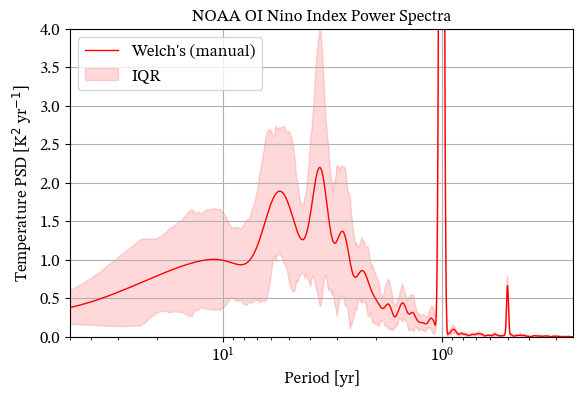

In [31]:
# NOAA OI power spectra 

fig, axis = plt.subplots(ncols=1, nrows=1, figsize=(6.5,4.0))

pd = f_welch_oi[1:]**-1

#plt.semilogx(pd,ps_welch_oi[1:],label="Welch's (function)",color='blue',linewidth=1.0)
#plt.fill_between(pd,ci_lower_oi,ci_upper_oi,alpha=0.25,label="95% C.I.",color='blue')

plt.semilogx(pd,ps_pgram_oi[1:],label="Welch's (manual)",color='red',linewidth=1.0)
#plt.plot(pd,ps_pgram_oi[1:],label="Welch's (manual)",color='red',linewidth=1.0)
plt.fill_between(pd,iqr_lower_oi[1:],iqr_upper_oi[1:],alpha=0.15,label="IQR",color='red')

#plt.xlim(max(pd), min(pd))  # inverting x-axis                                                                                                                                                                
#plt.xlim(min(pd), max(pd))
plt.xlim(50, .25)  

plt.ylim(0,4) 
plt.legend(fontsize=12,loc='upper left')
plt.xticks(fontsize=12); plt.yticks(fontsize=12);
plt.xlabel("Period [yr]",fontsize=12)
plt.ylabel("Temperature PSD [K$^2$ yr$^{-1}$]",fontsize=12)
plt.grid()
axis.set_title('NOAA OI Nino Index Power Spectra')

fig.savefig('nino_index_noaa_welch.jpg', bbox_inches='tight', dpi=400, format='jpeg')

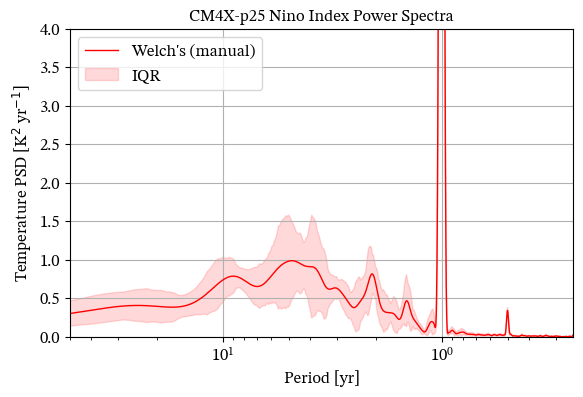

In [32]:
# CM4X-p25 power spectra 

fig, axis = plt.subplots(ncols=1, nrows=1, figsize=(6.5,4.0))

pd = f_welch_231[1:]**-1

#plt.semilogx(pd,ps_welch_231[1:],label="Welch's (function)",color='blue',linewidth=1.0)
#plt.fill_between(pd,ci_lower_231,ci_upper_231,alpha=0.25,label="95% C.I.",color='blue')

#plt.plot(pd,ps_pgram_231[1:],label="Welch's (manual)",color='red',linewidth=1.0)
plt.semilogx(pd,ps_pgram_231[1:],label="Welch's (manual)",color='red',linewidth=1.0)
plt.fill_between(pd,iqr_lower_231[1:],iqr_upper_231[1:],alpha=0.15,label="IQR",color='red')

#plt.xlim(max(pd), min(pd))  # inverting x-axis                                                                                                                                                                
#plt.xlim(min(pd), max(pd))
plt.xlim(50, .25)  

plt.ylim(0,4) 
plt.legend(fontsize=12,loc='upper left')
plt.xticks(fontsize=12); plt.yticks(fontsize=12);
plt.xlabel("Period [yr]",fontsize=12)
plt.ylabel("Temperature PSD [K$^2$ yr$^{-1}$]",fontsize=12)
plt.grid()
axis.set_title('CM4X-p25 Nino Index Power Spectra')

fig.savefig('nino_index_CM4Xp25_welch.jpg', bbox_inches='tight', dpi=400, format='jpeg')

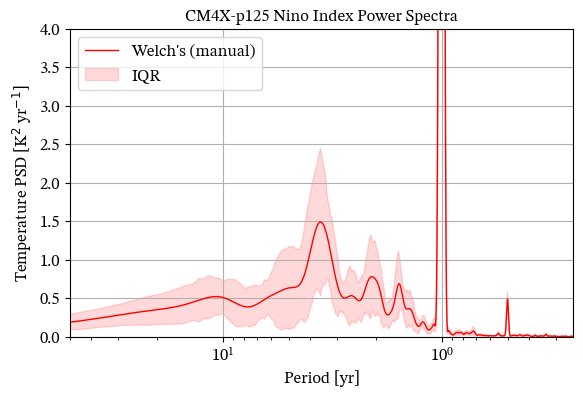

In [33]:
# CM4X-p125 power spectra 

fig, axis = plt.subplots(ncols=1, nrows=1, figsize=(6.5,4.0))

pd = f_welch_255[1:]**-1

#plt.semilogx(pd,ps_welch_255[1:],label="Welch's (function)",color='blue',linewidth=1.0)
#plt.fill_between(pd,ci_lower_255,ci_upper_255,alpha=0.25,label="95% C.I.",color='blue')

#plt.plot(pd,ps_pgram_255[1:],label="Welch's (manual)",color='red',linewidth=1.0)
plt.semilogx(pd,ps_pgram_255[1:],label="Welch's (manual)",color='red',linewidth=1.0)
plt.fill_between(pd,iqr_lower_255[1:],iqr_upper_255[1:],alpha=0.15,label="IQR",color='red')

#plt.xlim(max(pd), min(pd))  # inverting x-axis                                                                                                                                                                
#plt.xlim(min(pd), max(pd))
plt.xlim(50, .25)  

plt.ylim(0,4) 
plt.legend(fontsize=12,loc='upper left')
plt.xticks(fontsize=12); plt.yticks(fontsize=12);
plt.xlabel("Period [yr]",fontsize=12)
plt.ylabel("Temperature PSD [K$^2$ yr$^{-1}$]",fontsize=12)
plt.grid()
axis.set_title('CM4X-p125 Nino Index Power Spectra')

fig.savefig('nino_index_CM4Xp125_welch.jpg', bbox_inches='tight', dpi=400, format='jpeg')

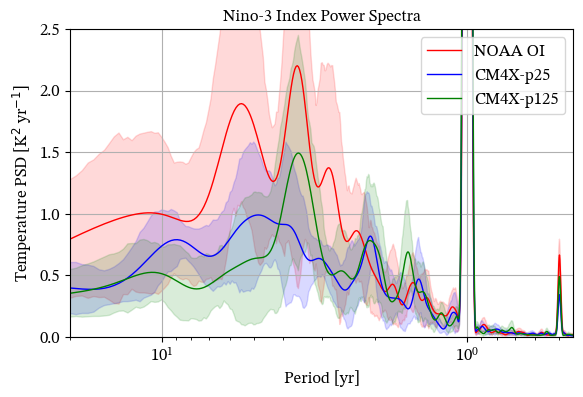

In [46]:
# NOAA OI power spectra 

fig, axis = plt.subplots(ncols=1, nrows=1, figsize=(6.5,4.0))

pd_oi = f_welch_oi[1:]**-1
plt.semilogx(pd_oi,ps_pgram_oi[1:],label="NOAA OI",color='red',linewidth=1.0)
plt.fill_between(pd,iqr_lower_oi[1:],iqr_upper_oi[1:],alpha=0.15,color='red')

pd_231 = f_welch_231[1:]**-1
plt.semilogx(pd_231,ps_pgram_231[1:],label="CM4X-p25",color='blue',linewidth=1.0)
plt.fill_between(pd,iqr_lower_231[1:],iqr_upper_231[1:],alpha=0.15,color='blue')

pd_255 = f_welch_255[1:]**-1
plt.semilogx(pd_255,ps_pgram_255[1:],label="CM4X-p125",color='green',linewidth=1.0)
plt.fill_between(pd,iqr_lower_255[1:],iqr_upper_255[1:],alpha=0.15,color='green')


plt.xlim(20, .45)  

plt.ylim(0,2.5) 
plt.legend(fontsize=12,loc='upper right')
plt.xticks(fontsize=12); plt.yticks(fontsize=12);
plt.xlabel("Period [yr]",fontsize=12)
plt.ylabel("Temperature PSD [K$^2$ yr$^{-1}$]",fontsize=12)
plt.grid()
axis.set_title('Nino-3 Index Power Spectra')

fig.savefig('nino_index_welch.jpg', bbox_inches='tight', dpi=400, format='jpeg')